# Project Objective

The goal of this project is to develop a model (logistic regression) that predicts an individual's income based on given data, classifying it as either below 50k annually or above 50k annually.

# Importing data and packagaes

In [1]:
library(ggplot2)
library(caret)
library(dplyr)
library(stats)
library(pROC)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: lattice

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [2]:
# loading data
data <- read.csv("adult.csv", sep=',', header=TRUE)
head(data)

age,workclass,fnlwgt,education,educational.num,marital.status,occupation,relationship,race,gender,capital.gain,capital.loss,hours.per.week,native.country,income
25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [3]:
str(data)

'data.frame':	48842 obs. of  15 variables:
 $ age            : int  25 38 28 44 18 34 29 63 24 55 ...
 $ workclass      : Factor w/ 9 levels "?","Federal-gov",..: 5 5 3 5 1 5 1 7 5 5 ...
 $ fnlwgt         : int  226802 89814 336951 160323 103497 198693 227026 104626 369667 104996 ...
 $ education      : Factor w/ 16 levels "10th","11th",..: 2 12 8 16 16 1 12 15 16 6 ...
 $ educational.num: int  7 9 12 10 10 6 9 15 10 4 ...
 $ marital.status : Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 5 3 3 3 5 5 5 3 5 3 ...
 $ occupation     : Factor w/ 15 levels "?","Adm-clerical",..: 8 6 12 8 1 9 1 11 9 4 ...
 $ relationship   : Factor w/ 6 levels "Husband","Not-in-family",..: 4 1 1 1 4 2 5 1 5 1 ...
 $ race           : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 3 5 5 3 5 5 3 5 5 5 ...
 $ gender         : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 2 2 2 1 2 ...
 $ capital.gain   : int  0 0 0 7688 0 0 0 3103 0 0 ...
 $ capital.loss   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours.per.week : i

# Data Preprocessing


Changing the data type of the factor variable to character to avoid generating NA values when modifying certain names.

In [4]:
cols.num <- c("workclass","marital.status","native.country")
data[cols.num] <- sapply(data[cols.num],as.character)
sapply(data, class)

age       workclass          fnlwgt       education educational.num 
      "integer"     "character"       "integer"        "factor"       "integer" 
 marital.status      occupation    relationship            race          gender 
    "character"        "factor"        "factor"        "factor"        "factor" 
   capital.gain    capital.loss  hours.per.week  native.country          income 
      "integer"       "integer"       "integer"     "character"        "factor"


Replacing the entries "Federal-gov" and "Local-gov" with "SL-gov" in the type_employer column.

In [5]:
data$workclass[data$workclass %in% c("Local-gov","Federal-gov")] <- "SL-gov"
unique(data$workclass)

[1] "Private"          "SL-gov"           "?"                "Self-emp-not-inc"
[5] "State-gov"        "Self-emp-inc"     "Without-pay"      "Never-worked"

Replacing the entries "Self-emp-inc" and "Self-emp-not-inc" with "self-emp" in the type_employer column.

In [6]:
data$workclass[data$workclass %in% c("Self-emp-inc","Self-emp-not-inc")] <- "Self-emp"
unique(data$workclass)

[1] "Private"      "SL-gov"       "?"            "Self-emp"     "State-gov"   
[6] "Without-pay"  "Never-worked"

Reducing the number of entries to three (Married, Not-Married, Never-Married) in the marital column.

In [7]:
data$marital.status[data$marital.status %in% c("Divorced","Widowed")] <- "Not-Married"

data$marital.status[data$marital.status %in% c("Separated", "Married-civ-spouse",
                                               "Married-spouse-absent",
                                               "Married-AF-spouse")] <- "Married"

In [8]:
unique(data$marital.status)

[1] "Never-married" "Married"       "Not-Married"

Reducing the number of entries in the country column by grouping them by continents.

The countries have been divided according to continents.

In [9]:
data$native.country[data$native.country %in% c("United-States", "Canada", "Outlying-US(Guam-USVI-etc)",
                         "Mexico", "Cuba", "Jamaica", "Haiti", "Dominican-Republic",
                         "Guatemala", "El-Salvador", "Nicaragua", "Trinadad&Tobago",
                         "Puerto-Rico", "Honduras")] <- "North-America"
data$native.country[data$native.country %in% c("England", "Germany", "Italy","Poland","Portugal",
                         "France", "Yugoslavia", "Scotland", "Greece",
                         "Ireland", "Hungary", "Holand-Netherlands")] <- "Europe"
data$native.country[data$native.country %in% c("Ecuador", "Peru", "Columbia", "South")] <- "South-America"
data$native.country[data$native.country %in% c("India", "Iran", "Philippines", "Cambodia",
                         "Thailand", "Laos", "Taiwan", "China", "Japan",
                         "Vietnam", "Hong")] <- "Asia"

In [10]:
unique(data$native.country)

[1] "North-America" "?"             "South-America" "Europe"       
[5] "Asia"

Replacing the entries "?" with NA values.

In [11]:
data[data == "?"] <- NA
table(is.na(data))


 FALSE   TRUE 
726165   6465 

Removing the rows containing NA entries.

In [12]:
data <- data[complete.cases(data), ]
table(is.na(data))


 FALSE 
678330 

Additional data transformations - changing data types.

In [13]:
data$age <- as.numeric(data$age)
data$fnlwgt <- as.numeric(data$fnlwgt)
data$educational.num <- as.numeric(data$educational.num)
data$capital.gain <- as.numeric(data$capital.gain)
data$capital.loss <- as.numeric(data$capital.loss)
data$hours.per.week <- as.numeric(data$hours.per.week)

In [14]:
data$workclass <- as.factor(data$workclass)
data$marital.status <- as.factor(data$marital.status)
data$native.country <- as.factor(data$native.country)

In [15]:
sapply(data, class)

age       workclass          fnlwgt       education educational.num 
      "numeric"        "factor"       "numeric"        "factor"       "numeric" 
 marital.status      occupation    relationship            race          gender 
       "factor"        "factor"        "factor"        "factor"        "factor" 
   capital.gain    capital.loss  hours.per.week  native.country          income 
      "numeric"       "numeric"       "numeric"        "factor"        "factor"

# Model Building and Evaluation

Dividing the data into a training set and a test set.

In [16]:
table(data$income)
y <- data$income


<=50K  >50K 
34014 11208 

Spliting the data into halves: 50% for the training set and 50% for the test set.

In [17]:
set.seed(321)
test_index <- createDataPartition(y, times = 1, p = 0.5, list = FALSE)
train_set <- data[test_index, ]
test_set <- data[-test_index, ]

In [18]:
dim(train_set)
dim(test_set)

[1] 22611    15

[1] 22611    15

Building a model using the glm function.

In [19]:
model = glm(income ~ ., data = train_set, family = "binomial")
summary(model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = income ~ ., family = "binomial", data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0726  -0.5245  -0.2016  -0.0206   3.5897  

Coefficients: (1 not defined because of singularities)
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -5.833e+00  4.199e-01 -13.894  < 2e-16 ***
age                          2.415e-02  1.942e-03  12.434  < 2e-16 ***
workclassSelf-emp           -2.832e-01  6.255e-02  -4.527 5.98e-06 ***
workclassSL-gov              7.461e-02  6.905e-02   1.081 0.279893    
workclassState-gov          -2.761e-01  1.050e-01  -2.629 0.008552 ** 
workclassWithout-pay        -5.015e-01  1.148e+00  -0.437 0.662104    
fnlwgt                       7.628e-07  1.980e-07   3.853 0.000117 ***
education11th                2.105e-01  2.426e-01   0.868 0.385579    
education12th                5.950e-01  3.027e-01   1.966 0.049295 *  
education1st-4th            -1.032e+00  6.353e-0

Refining the model using the step function.

In [20]:
step.model <- step(model)
summary(step.model)

Start:  AIC=14996.41
income ~ age + workclass + fnlwgt + education + educational.num + 
    marital.status + occupation + relationship + race + gender + 
    capital.gain + capital.loss + hours.per.week + native.country



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning mess


Step:  AIC=14996.41
income ~ age + workclass + fnlwgt + education + marital.status + 
    occupation + relationship + race + gender + capital.gain + 
    capital.loss + hours.per.week + native.country



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                 Df Deviance   AIC
<none>                 14890 14996
- race            4    14905 15003
- fnlwgt          1    14905 15009
- workclass       4    14921 15019
- native.country  3    14920 15020
- marital.status  2    14938 15040
- gender          1    14937 15041
- age             1    15046 15150
- capital.loss    1    15157 15261
- hours.per.week  1    15174 15278
- relationship    5    15317 15413
- occupation     13    15373 15453
- education      15    15625 15701
- capital.gain    1    16161 16265



Call:
glm(formula = income ~ age + workclass + fnlwgt + education + 
    marital.status + occupation + relationship + race + gender + 
    capital.gain + capital.loss + hours.per.week + native.country, 
    family = "binomial", data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0726  -0.5245  -0.2016  -0.0206   3.5897  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -5.833e+00  4.199e-01 -13.894  < 2e-16 ***
age                          2.415e-02  1.942e-03  12.434  < 2e-16 ***
workclassSelf-emp           -2.832e-01  6.255e-02  -4.527 5.98e-06 ***
workclassSL-gov              7.461e-02  6.905e-02   1.081 0.279893    
workclassState-gov          -2.761e-01  1.050e-01  -2.629 0.008552 ** 
workclassWithout-pay        -5.015e-01  1.148e+00  -0.437 0.662104    
fnlwgt                       7.628e-07  1.980e-07   3.853 0.000117 ***
education11th                2.105e-01  2.426e-01   0.86

In [21]:
step.model$call

glm(formula = income ~ age + workclass + fnlwgt + education + 
    marital.status + occupation + relationship + race + gender + 
    capital.gain + capital.loss + hours.per.week + native.country, 
    family = "binomial", data = train_set)

Testing the model on the test data and generating a confusion matrix.

In [22]:
pred <- predict(step.model, newdata = test_set)
y_hat <- ifelse(pred> 0.5, ">50K", "<=50K")
y_hat <- factor(y_hat, levels = levels(test_set$income))

In [23]:
pred.table = table(predicted = y_hat, actual = test_set$income)
pred.table

         actual
predicted <=50K  >50K
    <=50K 16311  2851
    >50K    696  2753

Evaluating the model using the confusionMatrix function to obtain the same values.

In [24]:
confusionMatrix(data = y_hat, reference = test_set$income)

Confusion Matrix and Statistics

          Reference
Prediction <=50K  >50K
     <=50K 16311  2851
     >50K    696  2753
                                          
               Accuracy : 0.8431          
                 95% CI : (0.8383, 0.8478)
    No Information Rate : 0.7522          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.517           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9591          
            Specificity : 0.4913          
         Pos Pred Value : 0.8512          
         Neg Pred Value : 0.7982          
             Prevalence : 0.7522          
         Detection Rate : 0.7214          
   Detection Prevalence : 0.8475          
      Balanced Accuracy : 0.7252          
                                          
       'Positive' Class : <=50K           
                  

Evaluating the classification model using the ROC curve.

Setting levels: control = <=50K, case = >50K
Setting direction: controls < cases


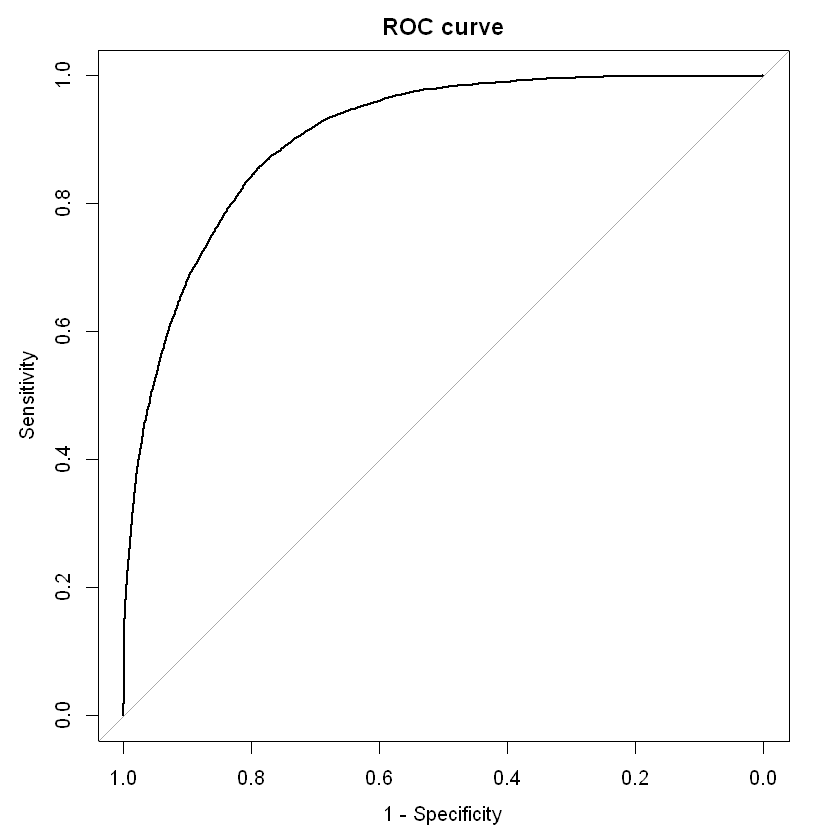

In [27]:
roc <- roc(test_set$income, pred)
plot(roc, main = "ROC curve", xlab = "1 - Specificity", ylab = "Sensitivity")

**AUC - Area Under the Curve**

AUC is a measure of the overall performance of a classification model based on the ROC curve. The AUC value ranges from 0 to 1, where:

* AUC = 1: Perfect classifier
* AUC = 0.5: Random classifier
* AUC < 0.5: Inverted or incorrect classifier (worse than random)


In general, the larger the AUC value, the better the classifier's performance in distinguishing between the positive and negative classes.

In [28]:
auc <- auc(roc)
auc

Area under the curve: 0.9048

AUC > 0.9 indicates a good fit of the model.

**Gini Coefficient (GC)**

The Gini coefficient is another metric commonly used to evaluate the performance of a classification model. It measures the inequality or impurity of the predicted classes. The Gini coefficient ranges from 0 to 1, where:

* GC = 1: Perfect classifier (all instances are correctly classified into their respective classes)
* GC = 0: Random classifier (the distribution of instances across classes is completely random)

In general, the larger the Gini coefficient, the better the classifier's performance in terms of class separation and minimizing impurity.

In [29]:
gc <- 2*auc-1
gc

[1] 0.8096865

GC > 0.8 also indicates a good fit of the model.

# Calculating the F1-score for the developed model.

TP, FP, FN, TN are abbreviations commonly used in confusion matrices to represent different classifications:

* TP (True Positive): It refers to the number of correctly predicted positive instances or the number of instances correctly classified as the positive class.
* FP (False Positive): It represents the number of instances that were incorrectly predicted as positive or the number of instances classified as the positive class when they actually belong to the negative class.
* FN (False Negative): It indicates the number of instances that were incorrectly predicted as negative or the number of instances classified as the negative class when they actually belong to the positive class.
* TN (True Negative): It refers to the number of correctly predicted negative instances or the number of instances correctly classified as the negative class.

In [30]:
TP <- pred.table[1,1]
FP <- pred.table[1,2]
FN <- pred.table[2,1]
TN <- pred.table[2,2]

Sensitivity (also known as Recall) is a measure that determines the model's ability to correctly detect positive instances. It is the proportion of true positive cases (TP) to the sum of true positive cases (TP) and false negative cases (FN).



Accuracy is a measure of the overall correctness of the model, representing the ratio of correctly classified cases (both positive and negative) to the total number of cases.



In [31]:
TPR <- TP/(TP+FN)
TPR

[1] 0.9590757

Specificity is a measure that determines the model's ability to correctly detect negative instances. It is the proportion of true negative cases (TN) to the sum of true negative cases (TN) and false positive cases (FP).

In [32]:
TNR <- TN/(TN+FP)
TNR

[1] 0.4912562

Precision (also known as Positive Predictive Value) is a measure that determines the accuracy of positive predictions made by the model. It is the proportion of true positive cases (TP) to the sum of true positive cases (TP) and false positive cases (FP).

In [33]:
PPV <- TP/(TP+FP)
PPV

[1] 0.8512159

**F1-score**

F1-score is a metric that combines precision and recall (sensitivity) into a single value, providing a balanced measure of accuracy. It is the harmonic mean of precision and recall.

The F1-score takes into account both the precision (ability to avoid false positives) and recall (ability to detect true positives) of the model. It is particularly useful in situations where there is an imbalance between positive and negative instances in the dataset. A high F1-score indicates a good balance between precision and recall, indicating a reliable and accurate model performance.

In [34]:
f1_score = 2*(TPR*PPV)/(TPR+PPV)
f1_score

[1] 0.9019326

The highest possible value for the F1-score is 1.0, which indicates perfect precision and recall. This means that the model achieves both high precision in its positive predictions and high recall in identifying true positive cases. On the other hand, the lowest possible value for the F1-score is 0, which occurs when either precision or recall is zero. This indicates that the model fails to correctly predict positive cases or fails to identify any true positive cases.

# Changing the Data Proportions

Evaluation of the model when we increase the proportion between the amount of data in the training and test sets:

* 80% training set
* 20% test set

In [35]:
set.seed(321)
test_index <- createDataPartition(y, times = 1, p = 0.8, list = FALSE)
train_set <- data[test_index, ]
test_set <- data[-test_index, ]

Model

In [36]:
model = glm(income ~ ., data = train_set, family = "binomial")
summary(model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = income ~ ., family = "binomial", data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0642  -0.5226  -0.1999  -0.0232   3.5802  

Coefficients: (1 not defined because of singularities)
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -6.113e+00  3.322e-01 -18.399  < 2e-16 ***
age                          2.536e-02  1.534e-03  16.525  < 2e-16 ***
workclassSelf-emp           -3.161e-01  4.928e-02  -6.414 1.41e-10 ***
workclassSL-gov              2.171e-02  5.518e-02   0.393 0.693980    
workclassState-gov          -3.095e-01  8.278e-02  -3.739 0.000185 ***
workclassWithout-pay        -5.439e-01  8.042e-01  -0.676 0.498857    
fnlwgt                       6.707e-07  1.587e-07   4.227 2.37e-05 ***
education11th                2.097e-01  1.957e-01   1.072 0.283937    
education12th                5.247e-01  2.521e-01   2.081 0.037440 *  
education1st-4th            -8.900e-01  4.770e-0

Improving model with step function.

In [37]:
step.model <- step(model)
summary(step.model)

Start:  AIC=23808.46
income ~ age + workclass + fnlwgt + education + educational.num + 
    marital.status + occupation + relationship + race + gender + 
    capital.gain + capital.loss + hours.per.week + native.country



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning mess


Step:  AIC=23808.46
income ~ age + workclass + fnlwgt + education + marital.status + 
    occupation + relationship + race + gender + capital.gain + 
    capital.loss + hours.per.week + native.country



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                 Df Deviance   AIC
<none>                 23703 23809
- fnlwgt          1    23720 23824
- race            4    23732 23830
- native.country  3    23745 23845
- workclass       4    23758 23856
- marital.status  2    23765 23867
- gender          1    23804 23908
- age             1    23978 24082
- capital.loss    1    24042 24146
- hours.per.week  1    24106 24210
- occupation     13    24413 24493
- relationship    5    24431 24527
- education      15    24916 24992
- capital.gain    1    25766 25870



Call:
glm(formula = income ~ age + workclass + fnlwgt + education + 
    marital.status + occupation + relationship + race + gender + 
    capital.gain + capital.loss + hours.per.week + native.country, 
    family = "binomial", data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0642  -0.5226  -0.1999  -0.0232   3.5802  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -6.113e+00  3.322e-01 -18.399  < 2e-16 ***
age                          2.536e-02  1.534e-03  16.525  < 2e-16 ***
workclassSelf-emp           -3.161e-01  4.928e-02  -6.414 1.41e-10 ***
workclassSL-gov              2.171e-02  5.518e-02   0.393 0.693980    
workclassState-gov          -3.095e-01  8.278e-02  -3.739 0.000185 ***
workclassWithout-pay        -5.439e-01  8.042e-01  -0.676 0.498857    
fnlwgt                       6.707e-07  1.587e-07   4.227 2.37e-05 ***
education11th                2.097e-01  1.957e-01   1.07

Prediction table

In [38]:
pred <- predict(step.model, newdata = test_set)
y_hat <- ifelse(pred> 0.5, ">50K", "<=50K")
y_hat <- factor(y_hat, levels = levels(test_set$income))
pred.table = table(predicted = y_hat, actual = test_set$income)
pred.table

         actual
predicted <=50K >50K
    <=50K  6546 1189
    >50K    256 1052

F1-score

In [39]:
TP <- pred.table[1,1]
FP <- pred.table[1,2]
FN <- pred.table[2,1]
TN <- pred.table[2,2]

TPR <- TP/(TP+FN) #dokładność
TNR <- TN/(TN+FP) #specyficzność
PPV <- TP/(TP+FP) #precyzja

f1_score = 2*(TPR*PPV)/(TPR+PPV)
f1_score

[1] 0.9005985

The obtained model has a lower F1-score value compared to the previous model.

# Project Summary:


The aim of this project was to develop a logistic regression model that could predict a person's income based on the available data. Various data transformations were performed, such as changing data types, handling missing values, and reducing the number of entries in certain columns.

Next, the data was split into training and testing sets in different proportions, and a logistic regression model was built using the glm function. Additionally, the step function was used to refine the model through variable selection.

The model was tested on the test set, and the results were evaluated using various metrics including confusion matrix, ROC curve, AUC, Gini coefficient, and F1-score.

Upon analysis, it was found that the obtained model has a lower F1-score compared to the previous model. This indicates that the developed model may have lower balanced accuracy in classification.

In summary, although the logistic regression model was built and tested on the available data, there is still room for improvement in its performance through further fine-tuning, selecting relevant variables, or applying other modeling techniques.